In [21]:
from pre_processing import *
import seaborn as sns

## Data processing
Load data in a single dataframe

In [22]:
PATH = './Train/Train'

df = load_general(PATH)



Perform data processing and basic feature selection

In [23]:
#drop instance where there's no number of bikes
df = drop_nan_bikes(df)

#replaces days with numbers
day_transform(df)

#replaces NaN with median
df = nan_impute(df)

#removes features with zero variance
df = var_transform(df)

has_nan(df)


(False,
 station                        0
 latitude                       0
 longitude                      0
 numDocks                       0
 timestamp                      0
 day                            0
 hour                           0
 weekday                        0
 weekhour                       0
 isHoliday                      0
 windMaxSpeed.m.s               0
 windMeanSpeed.m.s              0
 windDirection.grades           0
 temperature.C                  0
 relHumidity.HR                 0
 airPressure.mb                 0
 bikes_3h_ago                   0
 full_profile_3h_diff_bikes     0
 full_profile_bikes             0
 short_profile_3h_diff_bikes    0
 short_profile_bikes            0
 bikes                          0
 dtype: int64)

Find which feature has highest correlation with bikes

In [24]:
corr_matrix = correl(df)
print(corr_matrix['bikes'].sort_values(ascending=False).head(5))

bikes                  1.000000
bikes_3h_ago           0.671276
short_profile_bikes    0.574881
full_profile_bikes     0.574881
longitude              0.283121
Name: bikes, dtype: float64


Find inter-feature correlation and drop features with a correlation higher than 0.95

['day', 'weekhour', 'windMeanSpeed.m.s', 'short_profile_3h_diff_bikes', 'short_profile_bikes']


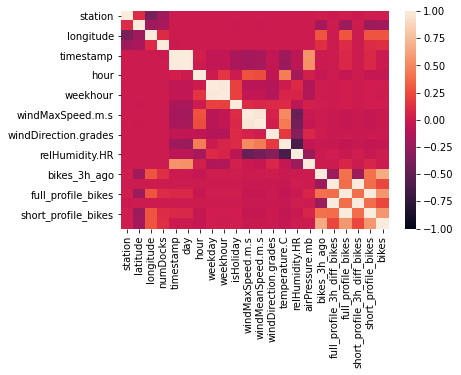

In [25]:
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0)

dropped = high_correl(df, 0.95)
print(dropped)

## Model selection